# [Programming assignment 3: Stance detection](http://www.cse.chalmers.se/~richajo/dit866/assignments/a3/assignment3.html)

### Authors: Pontus Vikstål, Leonard Schroven and Marin Kovač

In [1]:
# for handeling data
import pandas as pd

# for mathematical manipulation
import numpy as np

# the actual classification algorithm
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

# for converting training and test datasets into matrices
# TfidfVectorizer does this specifically for documents
from sklearn.feature_extraction.text import TfidfVectorizer

# for bundling the vectorizer and the classifier as a single "package"
from sklearn.pipeline import make_pipeline

# for splitting the dataset into training and test sets 
from sklearn.model_selection import train_test_split

# for evaluating the quality of the classifier
from sklearn.metrics import accuracy_score

#for plotting
import matplotlib.pyplot as plt

## Data preprocessing

In [2]:
# import the training data
df_train = pd.read_csv('http://www.cse.chalmers.se/~richajo/dit866/assignments/a3/data/a3_train_final.tsv',
                 sep='\t', header=None, names=["sentiment","comment"])

df_test = pd.read_csv('http://www.cse.chalmers.se/~richajo/dit866/assignments/a3/data/a3_test_final.tsv',
                 sep='\t', header=None, names=["sentiment","comment"])
df_test["sentiment"]= df_test["sentiment"].apply(str)

# look at the data
df_train.head()
df_test.tail()

,sentiment,comment
877,0,"“Be a guinea pig for the vaccine, the benefits..."
878,0,“Medical professionals” that don’t even eat he...
879,1,“This bridge is only 99% safe so we should jus...
880,0,“We cannot have normality until everyone globa...
881,1,”i’d do anything to keep my child safe” except...


In [3]:
# drop comments where the sentiments don't agree
l = [] # list with elements to drop

#count percentage of agreement
counter_agree = 0
counter_disagree = 0
counter_unsure= 0

for i in range(len(df_train)):
    # get the ith sentiment and split it into a list 
    sentiment = df_train["sentiment"][i].split('/')
    

    # check if the all the elements are the same
    if all(s == '-1' for s in sentiment) == True:
        # if all the elements are -1 drop that row
        l.append(i)
        counter_unsure = counter_unsure +1
    elif all(s == '0' or s == '-1' for s in sentiment) == True:
        # if all the elements are the same we just pick one of them
        df_train["sentiment"][i] = '0'
        counter_agree = counter_agree +1
    elif all(s == '1' or s == '-1' for s in sentiment) == True:
        # if all the elements are the same we just pick one of them
        df_train["sentiment"][i] = '1'
        counter_agree = counter_agree +1
    else:
        # if all the elements are not the same drop that row
        l.append(i)
        counter_disagree = counter_disagree +1

print("Agree:",counter_agree)
print("Disagree:",counter_disagree)
print("Unsure:",counter_unsure)
print("Percentage of Agree:",counter_agree/(counter_agree + counter_disagree + counter_unsure))
print("Percentage of Disagree:",counter_disagree/(counter_agree + counter_disagree + counter_unsure))
print("Percentage of Unsure:",counter_unsure/(counter_agree + counter_disagree + counter_unsure))

df_train_filtered = df_train.drop(l);

('Agree:', 15990)
('Disagree:', 918)
('Unsure:', 0)
('Percentage of Agree:', 0)
('Percentage of Disagree:', 0)
('Percentage of Unsure:', 0)


In [4]:
# split into train and test datasets
Ytrain = df_train_filtered.iloc[:,0]
Xtrain = df_train_filtered.iloc[:,1]
Ytest = df_test.iloc[:,0]
Xtest = df_test.iloc[:,1]

In [23]:
import re

def preprocess_text(text):
    text = text.lower() # make lower case
    text = re.sub(r'\d+', '', text) # remove digits
    return text

vectorizer = TfidfVectorizer(
        decode_error='strict',
        strip_accents='unicode',
        analyzer='word',
        min_df = 1,
        max_df = 0.8,
        ngram_range = (1,2),
        sublinear_tf = True,
        preprocessor=preprocess_text
    )
X_train = vectorizer.fit_transform(Xtrain)
X_test = vectorizer.transform(Xtest)
y_train = Ytrain
y_test = Ytest

feature_names = vectorizer.get_feature_names()

## Comparison of algorithms

In [6]:
from optparse import OptionParser
import sys
# to get the train time
from time import time

# accuracy
from sklearn import metrics

# a lot of classifiers to test
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# A function where we train and test the datasets with different classification models
# and get performance results for each model.
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

### Train all the classifiers for the comparison

In [24]:
results = []
# if we want to print some extra things
print_cm = 0 # print confusion matrix
print_report = 0 # print classification report

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    clf_descr, score, train_time, test_time = benchmark(LinearSVC(penalty=penalty,dual=False,
                                       tol=1e-3))
    clf_descr = clf_descr + ' ' +penalty.upper()
    results.append([clf_descr, score, train_time, test_time])

    # Train SGD model
    clf_descr, score, train_time, test_time = benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty))
    clf_descr = clf_descr + ' ' +penalty.upper()
    results.append([clf_descr, score, train_time, test_time])    
    
clf_descr, score, train_time, test_time = benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty='elasticnet'))
clf_descr = clf_descr + ' ' + 'elasticnet'
results.append([clf_descr, score, train_time, test_time])
# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(BernoulliNB(alpha=.01)))

# Train sparse Dummy classifier
print('=' * 80)
print("Dummy classifier")
results.append(benchmark(DummyClassifier()))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.715s
test time:  0.000s
accuracy:   0.902
dimensionality: 135105
density: 1.000000
()
()
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.366s
test time:  0.000s
accuracy:   0.888
dimensionality: 135105
density: 0.481248
()
()
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveCla

### Plot comparison of classification algorithms

The bar plot indicates the accuracy and training time (normalized) for each classifier.

('Best accuracy was given by ', 'RidgeClassifier', ' = ', 0.9024943310657596)


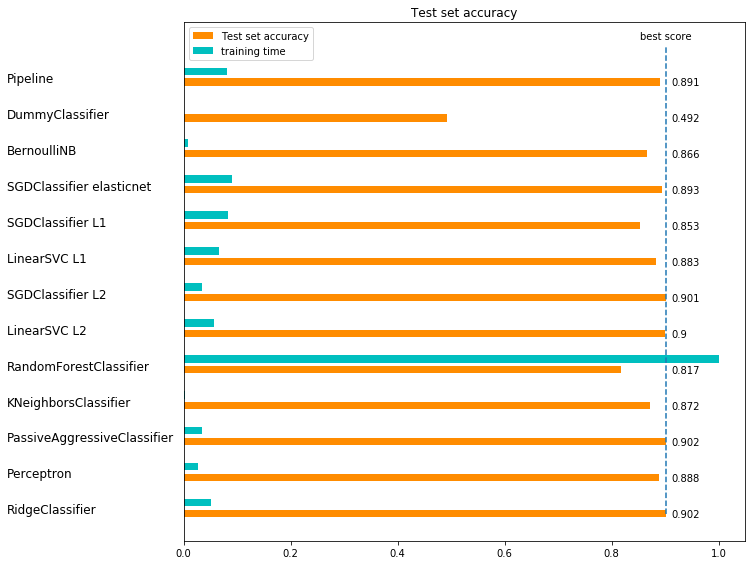

In [25]:
indices = np.arange(len(results))

results2 = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results2
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Test set accuracy")
plt.barh(indices, score, .2, label="Test set accuracy", color='darkorange')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
#plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
plt.plot([max(score),max(score)],[0,len(score)],"--")
plt.text(max(score)-0.05,len(score)+0.2,"best score")
score_str = [str(round(x,3)) for x in score]
for i in range(len(score)):
    plt.text(max(score)+0.01,i-0.1,score_str[i])

    

print("Best accuracy was given by ", clf_names[np.argmax(score)],' = ',max(score))

for i, c in zip(indices, clf_names):
    plt.text(-.33, i, c,fontsize = 'large')

plt.savefig('cmp_alg.eps', format='eps',bbox_inches='tight')
plt.show()

## SGDClassifier anlysis
### Plot the feature importance graph

plots top n features for both the positive and the negative class for the best preforming algorithm

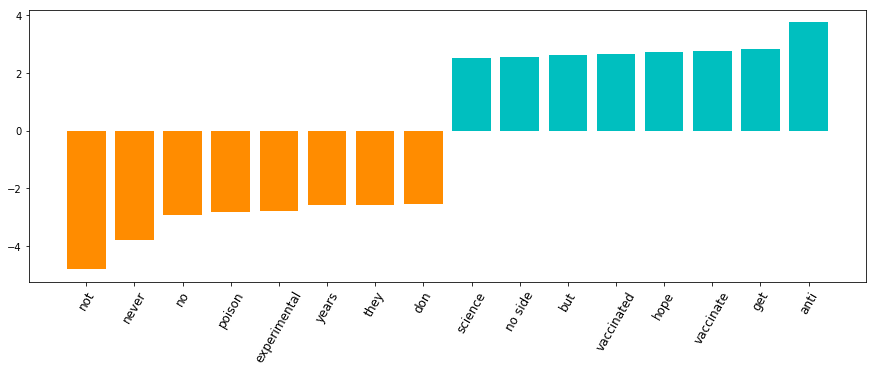

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["darkorange" if c < 0 else "c" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, fontsize = 'large')
    plt.savefig('feature.eps', format='eps',bbox_inches='tight')
    plt.show()
    

clf = SGDClassifier(alpha=.0001, max_iter=50,penalty='l2')
clf.fit(X_train, y_train)
plot_coefficients(clf, vectorizer.get_feature_names(),8)

### Plot the Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('confusion_matrix.eps', format='eps',bbox_inches='tight')
    return ax

('Accuracy of the test set: ', 0.9024943310657596)
('Accuracy of the train set: ', 0.9654158849280801)
Confusion matrix, without normalization
[[401  40]
 [ 46 395]]


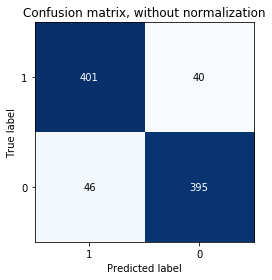

In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,clf.predict(X_test)) 
print("Accuracy of the test set: ",metrics.accuracy_score(y_test, clf.predict(X_test)))
print("Accuracy of the train set: ",metrics.accuracy_score(y_train, clf.predict(X_train)))
plot_confusion_matrix(y_test, clf.predict(X_test),[1,0])

### Print some wrong prediction for anlysis

In [29]:
Yguess = clf.predict(X_test)
a = (Yguess == y_test)
# wrong predictions
wp = [i for i, x in enumerate(a) if not x]
Ytest[wp[21]],Xtest[wp[21]]

('0',
 'I just automatically assume people who get the vaccine barely have the IQ to push a broom.')